In [1]:
""""
Design of the trail:
1.Structure
     - dimension mapping in the whole space transform process: (#1, #2, [...]). each # corresponds to an independent space, whose dimension is the value for the #.
     - design of non-linear scalar-valued function design of each dimension above: polynomial functions.
2.Fitting Algorithm
     - gradient descent
"""

import random
import numpy as np

"""
We start by designing the polynomial function of degree 3. To consider all possible terms in polynomials, we can leverage the method of Cartesian product and make some changes on it.
"""

"""
1. generate final result directly by something like `np.identity`?
2. ideas about store type: 
    - pure ndarray implementation (order is clear).
    - set(term_collection) -> set -> list.
3. structure design of `term`:
    - value('x_1'), power | matching by index -> not clear even possible.
    - 'x_1', power | matching by str -> more clear, and matching by str is easy.
    - [power1, power2, ...] for each idx -> less clear meaning, more memory, but more clear in structure. 
"""
def get_terms_collection(quantity_of_variables, max_degree):
    if max_degree == 1:
        return [np.identity(quantity_of_variables, dtype=np.int32)]

    """
    1. another idea for implementing `terms_collection_s`: add a new arg \
    'all_pre_terms_collection' in function.
    2. `tcfcdl`: terms_collection_for_certain_degree_list
    """
    tcfcdl = get_terms_collection(quantity_of_variables, max_degree - 1)

    terms_collection_for_one_smaller_degree = tcfcdl[-1]
    terms_collection_for_cur_max_degree = []

    for idx in range(quantity_of_variables):
        for pre_term in terms_collection_for_one_smaller_degree:
            pre_term_ = pre_term.copy()
            pre_term_[idx] += 1
            terms_collection_for_cur_max_degree.append(pre_term_)
        """
        another idea: generate `term_collector` by filtering something like \
        [1, 2], [2, 1] by set? seems wrong.
        """
        terms_collection_for_one_smaller_degree = list(filter(
            lambda term: term[idx] == 0,
            terms_collection_for_one_smaller_degree
        ))
    tcfcdl.append(np.array(terms_collection_for_cur_max_degree))
    return tcfcdl

a = get_terms_collection(2, 2)
""" 2000, 2 -> 2003000 """
a = np.vstack(a)
# print(a)
print(len(a))

5


In [2]:
class ENN():
    def __init__(self, **config):
        """ initialize the default config. ref: see `simple_nn.ipynb` """
        self.config = lambda: 0

        self.config.feature_dimension = 2
        self.config.num_of_class = 2
        self.config.space_mapping_process = (self.config.feature_dimension,
                                             self.config.num_of_class)
        self.config.max_degree = 1
        self.config.learning_rate = 1
        self.config.batch_size = 100
        
        """ override config with custom hyper-parameters if any. """
        for k, v in config.items():
            if getattr(self.config, k, None):
                setattr(self.config, k, v)
            else:
                raise AttributeError('Unknown hyper-parameter %s' % k)
        
        """ `fp_trasformation`: feature_polynomial_transformation """
        self.fp_transformation  = np.vstack(get_terms_collection(
            self.config.feature_dimension, self.config.max_degree))
        
        """
        `W`: coefficients_for_all_dimension_in_next_space
        len of `fp_transformation`: quantity_of_variable_term
        """
        self.W = np.random.normal(size=(
            len(self.fp_transformation), self.config.space_mapping_process[1]))
        
        """ `b`: constant_coefficient_for_all_dimension_in_next_space """
        self.b = np.random.random((self.config.space_mapping_process[1], ))
        
    def feature_transform(self, feature_input_s):
        feature_output_s = []
        for x in feature_input_s:
            feature_output_s.append([
                sum(var ** power if power != 0 else 0 for var, power in zip(
                    x, term)) for term in self.fp_transformation
            ])            
        return np.array(feature_output_s)
            
    """ backpropagation """
    """ note that `x_s_train` is just an alias of `feature_input_s`. """
    def fit(self, x_s_train, y_s_train, *, steps=1000, \
            params_trace_recording=False):
        x_s_train, y_s_train = np.array(x_s_train), np.array(y_s_train)
        W_trace, b_trace = [self.W.copy()], [self.b.copy()]
        W_gradients_trace, b_gradients_trace = [], []
        sample_size = len(x_s_train)
        
        for step in range(steps):
            indices_batch = random.sample(
                range(sample_size), self.config.batch_size)

            """ i corresponds to row in `self.W` and j to col. """
            """ define them as function without actual object reference can \
            free memory at soon. and I think it's faster than del statement. """
            x_s = self.feature_transform(x_s_train[indices_batch])
            y_minus_f_s = x_s.dot(self.W) + self.b - y_s_train[indices_batch]

            """ 
            1. `pd`: partial derivative 
            2. `l_on_f`: all the loss_j on the f_j
            3. `fj_on_w__j`: all the fj on the w_ij when j is fixed
            """
            pd_of_l_on_f_s = \
            2 / self.config.space_mapping_process[1] * y_minus_f_s
            pd_of_fj_on_w__j_s = x_s
            
            W_gradients = np.mean(
                pd_of_fj_on_w__j_s[:, :, np.newaxis] @ \
                pd_of_l_on_f_s[:, np.newaxis, :], axis=0)
            b_gradients = np.mean(
                pd_of_l_on_f_s, axis=0)
                        
            self.W -= self.config.learning_rate * W_gradients
            self.b -= self.config.learning_rate * b_gradients
            
            if params_trace_recording:
                """ attention this! """
                W_trace.append(self.W.copy())
                b_trace.append(self.b.copy())
                W_gradients_trace.append(W_gradients.copy())
                b_gradients_trace.append(b_gradients.copy())
        print('training completed.') 
        return W_trace, b_trace, W_gradients_trace, b_gradients_trace

    # forward computing        
    def logits(self, x_s, W=None, b=None):
        if W is not None and b is not None:
            return self.feature_transform(x_s).dot(W) + \
                b
        else:
            return self.feature_transform(x_s).dot(self.W) + self.b

    def predict(self, x_s, W=None, b=None):
        return np.argmax(self.logits(x_s, W=W, b=b), axis=1)

<font face='Goudy Old Style' size=5><span style="color:rgb(0, 92, 84);">Step 1: Prepare the data set</span></font>

<IPython.core.display.Javascript object>


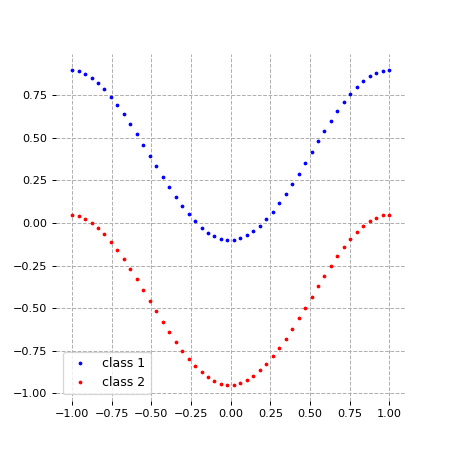

<font face='Goudy Old Style' size=5><span style="color:rgb(0, 92, 84);">Step 2: Training Process</span></font>

training completed.


<font face='Goudy Old Style' size=5><span style="color:rgb(0, 92, 84);">Step 3: Training Process Plotting</span></font>

gradients:


<IPython.core.display.Javascript object>


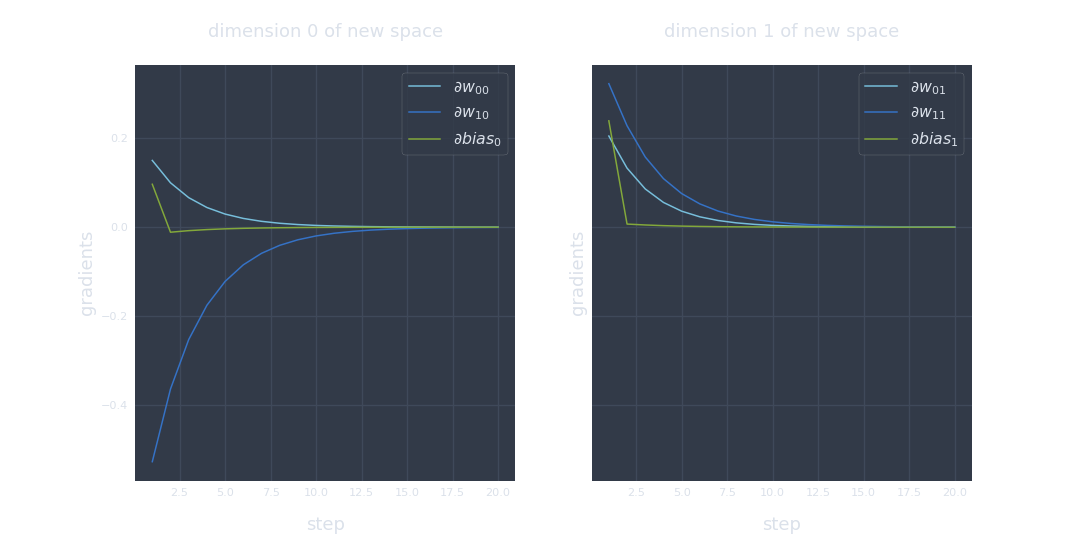

weights (generated by the trace of gradients):


<IPython.core.display.Javascript object>


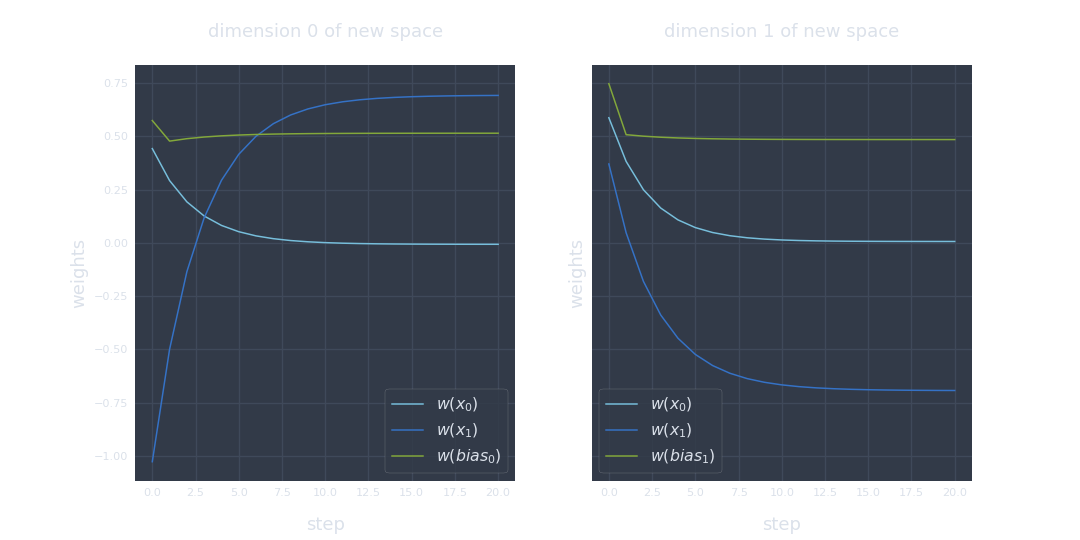

1 Training Accuracy: 0.13


<IPython.core.display.Javascript object>


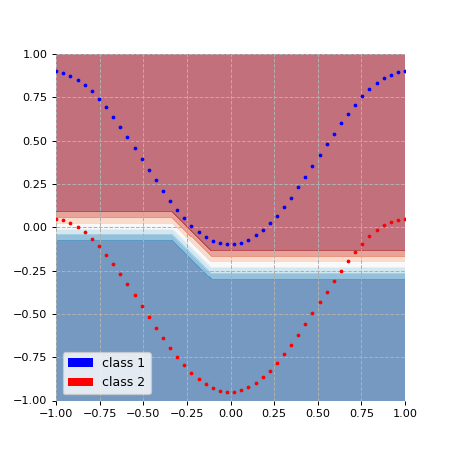

<IPython.core.display.Javascript object>


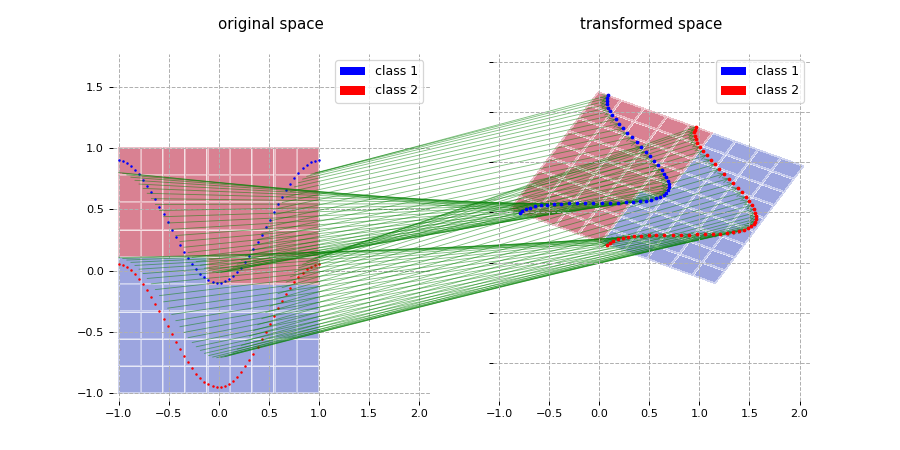

interactive(children=(IntSlider(value=0, description='step', max=20), Output()), _dom_classes=('widget-interac…

In [8]:
import numpy as np
%matplotlib notebook
import ipywidgets as widgets
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from mpl_toolkits.mplot3d import Axes3D

import feature_visualization as fv
from feature_visualization import md_display

fv.reset()
md_display('Step 1: Prepare the data set')
fig, ax = plt.subplots(1, 1, figsize=(5,5), sharex=True, sharey=True)
fv.style_initialize(ax)
[x_coords, y_coords] = fv.sampling('quadratic', 'matplotlib', 50)
xy1 = np.array([x_coords, y_coords+0.4])
xy2 = np.array([x_coords, y_coords-0.45])
ax.plot(*xy1, 'bo', markersize=2, )
ax.plot(*xy2, 'ro', markersize=2, )
ax.legend(['class 1', 'class 2'])
plt.show()


md_display('Step 2: Training Process')
""" `x` here means input feature vector x """
x_s_train = np.hstack([xy1, xy2]).T
y_s_train = np.array([[1, 0]]*50 + [[0, 1]]*50)
enn = ENN(max_degree=1)    
W_trace, b_trace, W_gradients_trace, b_gradients_trace = enn.fit(
    x_s_train, y_s_train, steps=20, params_trace_recording=True)
W_trace, b_trace = np.array(W_trace), np.array(b_trace)
W_gradients_trace, b_gradients_trace = \
    np.array(W_gradients_trace), np.array(b_gradients_trace)


md_display('Step 3: Training Process Plotting')
def coefficients_format_conversion(W_trace, b_trace, origin):
    """
    convert `W` and `b` (or their gradients) trace to matplotlib format.
    :param origin: 
        0 or 1. the x coordinate of origin when plotting. 0 corresponds to \
        plotting gradients, and 1 to plotting weights.
    """
    steps = range(origin, len(W_trace) + origin)
    coeffs_all_dim = [] 
    for j_dim in range(W_trace.shape[2]):
        coeffs_j_dim = []
        for i_term in range(W_trace.shape[1]):
            coeffs_j_dim += [steps, W_trace[:, i_term, j_dim]]
        coeffs_j_dim += [steps, b_trace[:, j_dim]]
        coeffs_all_dim.append(coeffs_j_dim.copy())
    return np.array(coeffs_all_dim)

def get_terms_for_display(terms):
    legend = []
    for i, term in enumerate(terms):
        legend.append(r'$w(' + ''.join([
            r'' if not pow_ \
                else r'x_{%(idx)s}' % {'idx': idx} if pow_ == 1 \
                else r'x^{%(pow)s}_{%(idx)s}' % {'pow': pow_, 'idx': idx} \
                for idx, pow_ in enumerate(term)
        ]) + ')$')
    legend.append(r'$w(bias_j)$')
    return legend

def params_plot(step):
    print('gradients:')
    fv.feature_plot(
        *coefficients_format_conversion(W_gradients_trace, b_gradients_trace, 
            1),
        legend = [r'$\partial{w_{i j}}$'.replace('i ', str(i)) 
            for i in range(W_trace.shape[1])] \
               + [r'$\partial{bias_j}$'],
        x_highlight=step,
        axis_title=r'dimension j of new space',
        axis_label=['step', 'gradients'],
    )

    print('weights (generated by the trace of gradients):')
    fv.feature_plot(
        *coefficients_format_conversion(W_trace, b_trace, 0),
        legend=get_terms_for_display(enn.fp_transformation),
        x_highlight=step,
        axis_title=r'dimension j of new space',
        axis_label=['step', 'weights'],
    )

fv.jtplot.style('chesterish')
params_plot(-1)
fv.reset()
sampling_magnitude = 10
grid = (sampling_magnitude, sampling_magnitude)
xy_coords_test = fv.sampling('square', 'matplotlib', sampling_magnitude)
handles=[
    Patch(facecolor='b', label='class 1'),
    Patch(facecolor='r', label='class 2'),
]

    
""" nonlinear scalar-valued function learned plotting """
# fig = plt.figure(figsize=(12,6))
# ax1 = fig.add_subplot(1,2,1, projection='3d')
# ax1.plot_surface(*xy_coords_test.reshape(2, *grid), f3[0].reshape(grid))
# ax1.set_title('nonlinear function learned of dim 0', y=1.05)
# ax2 = fig.add_subplot(1,2,2, projection='3d')
# ax2.plot_surface(*xy_coords_test.reshape(2, *grid), f3[1].reshape(grid))
# ax2.set_title('nonlinear function learned of dim 1', y=1.05)

# ax1._shared_z_axes.join(ax1, ax2)
# _ = (*ax1.get_zlim(), *ax2.get_zlim())
# new_zlim = min(_), max(_)
# ax1.set_zlim(new_zlim)

labels_test = enn.predict(
    xy_coords_test.T, W_trace[0], b_trace[0]).reshape(grid)
f = lambda _: enn.logits(_.T, W_trace[0], b_trace[0]).T
f1, f2, f3 = f(xy1), f(xy2), f(xy_coords_test)

fv.reset()
""" decision boundary plotting (`db`: decision boundary) """
fig_db, ax_db = plt.subplots(figsize=(5,5))
fv.style_initialize(ax_db)
db = ax_db.contourf(
    *xy_coords_test.reshape(2, *grid), labels_test, 
    cmap='RdBu_r', alpha=0.6)
ax_db.plot(*xy1, 'bo', markersize=2, )
ax_db.plot(*xy2, 'ro', markersize=2, )
ax_db.legend(handles=handles)
acc_train = np.mean(
    enn.predict(x_s_train, W_trace[0], b_trace[0]) == np.argmax(y_s_train, 1))
print('1 Training Accuracy:', acc_train)


""" transformation plotting """
fig_t, axes_t = plt.subplots(1, 2, figsize=(10,5), sharex=True, sharey=True)
fv.style_initialize(axes_t)
# axes_t = [0, axes_t]

lines_t =[]
for ax, xy in zip(axes_t, [xy_coords_test, f3]):
    t = ax.pcolormesh(*xy.reshape(2, *grid), labels_test, 
        cmap='coolwarm', edgecolor='white', alpha=0.5)
    ax.grid(True, linestyle='--', alpha=1.)
    ax.legend(handles=handles)
axes_t[0].set_title('original space', y=1.05)
axes_t[1].set_title('transformed space', y=1.05)
axes_t[0].plot(*xy1, 'bo', markersize=1, )
axes_t[0].plot(*xy2, 'ro', markersize=1, )
lines_t.append(axes_t[1].plot(*f1, 'bo', markersize=2, ))
lines_t.append(axes_t[1].plot(*f2, 'ro', markersize=2, ))
#     print(f(np.array([x_coords, y_coords+0.4]))[:,:5])
#     print(f(np.array([x_coords, y_coords-0.45]))[:,:5])
con_s_1 = fv.connection_plot(axes_t[1], axes_t[0], f1, xy1)
con_s_2 = fv.connection_plot(axes_t[1], axes_t[0], f2, xy2)

""" `axis` will change data lim based current data. """
axes_t[1].axis('equal')

# lines_diag = []
# line = np.array([[-10,0,10], [-10,0,10]])
# pre_lim = axes_t[0].axis()
# for ax in axes_t: 
#     """ plot will update the datalim. """
#     lines_diag.append(ax.plot(*line, '--k', alpha=0.2, zorder=-1)[0])
#     ax.plot([0], [0], 'ko', zorder=-1)
# """ priority: lim setter > sharex & sharey """
# axes_t[0].axis(pre_lim)

# plt.show()
# plt.tight_layout()
plt.show()
def decision_trace_plot(step):
    """ `step`: the index of training step. """
    """ refreshing freq is too slow. how to optimize? """
    
    labels_test = enn.predict(
    xy_coords_test.T, W_trace[step], b_trace[step]).reshape(grid)
    f = lambda _: enn.logits(_.T, W_trace[step], b_trace[step]).T
    f1, f2, f3 = f(xy1), f(xy2), f(xy_coords_test)
    
#     fv.reset()
    global db
#     db.collections.clear()
    for _ in db.collections: _.remove()
    db = ax_db.contourf(
        *xy_coords_test.reshape(2, *grid), labels_test, 
        cmap='RdBu_r', alpha=0.6)
    acc_train = np.mean(
    enn.predict(x_s_train, W_trace[step], b_trace[step]) == np.argmax(y_s_train, 1))
    print('Training Accuracy:', acc_train)
    
    global t
    t.remove()
    t = axes_t[1].pcolormesh(*f3.reshape(2, *grid), labels_test, 
        cmap='coolwarm', edgecolor='white', alpha=0.5)
    axes_t[1].grid(True, linestyle='--', alpha=1.)
#         ax.lines.remove(l_diag)
    
    new_xlim = min(-1, f3[0].min())-0.06, max(1, f3[0].max())+0.06
    new_ylim = min(-1, f3[1].min())-0.06, max(1, f3[1].max())+0.06
    axes_t[1].set_xlim(new_xlim)
    axes_t[1].set_ylim(new_ylim)
    
#     lines_diag.clear()
#     for _ in lines_diag: _.set_visible(False)
    print('1',axes_t[1].axis())
    
#     print(ax.relim(visible_only=True))
#     ax.autoscale()
#     print('2', ax.axis())
#     for _ in lines_diag: _.set_visible(True)
    axes_t[1].lines[0].set_data(*f1)
    axes_t[1].lines[1].set_data(*f2)
    for con, xy in zip(con_s_1, f1.T):
        con.xy1 = xy
    for con, xy in zip(con_s_2, f2.T):
        con.xy1 = xy
        
#     """ `axis` will change data lim based current data. """
#     axes_t[0].axis('equal')
        
#     pre_lim = axes_t[1].axis()
#     for ax in axes_t: 
#         """ plot will update the datalim. """
#         lines_diag.append(ax.plot(*line, '--k', alpha=0.2, zorder=-1)[0])
# #         ax.plot([0], [0], 'ko', zorder=-1)
#     """ priority: lim setter > sharex & sharey """
#     axes_t[0].axis(pre_lim)
    
#     for ax in axes_t:
        
#     plt.tight_layout()
    plt.show()
        
    
    
    

widgets.interact(
    decision_trace_plot, step=widgets.IntSlider(min=0, max=len(W_trace)-1),)
pass
# print(W_trace[-3:])
# print(b_trace[-3:])

In [4]:
# print(W_trace[0])
# print(b_trace[0])
fv.md_display('$x_2$')

<font face='Goudy Old Style' size=5><span style="color:rgb(0, 92, 84);">$x_2$</span></font>

In [5]:
"""
Following Work:
- visualize the gradients, weights, bias. (1)
- multiple graphs visualization in the case of max degree of freedom > 2. (2)
- visualize the space transformation. (3)
- increase the degree of freedom of ENN.
- try to analyze the 3-d data.
- XOR problem.
- add softmax, observe the independence among the gradients, and so on.
- spiral curve problem, and so on.
- automatic derivatives calculation using sympy.
- optimize the calculation of value of the polynomial terms.
- linear cls (two line) & linear regression?
- would it converge faster when swapping the label blue and label red?
- remove the bias.
"""
pass

In [6]:
# print(dir(fv.jtplot))
# print(fv.jtplot.get_default_jtstyle())
# print(fv.jtplot.get_theme_style('grade3'))